Imports

In [ ]:
import re
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from transformers import BlipProcessor, BlipForQuestionAnswering

Randomness + Device

In [ ]:
SEED = 42

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
g = torch.Generator()
g.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Load Data (HuggingFace VQA-RAD)

In [ ]:
ds = load_dataset("flaviagiammarino/vqa-rad")
train_split = ds["train"]
test_split  = ds["test"]

print("Train:", len(train_split), "Test:", len(test_split))
print("Keys:", train_split[0].keys())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

Train: 1793 Test: 451
Keys: dict_keys(['image', 'question', 'answer'])


EDA

Question: what type of image is this?
Answer: x-ray


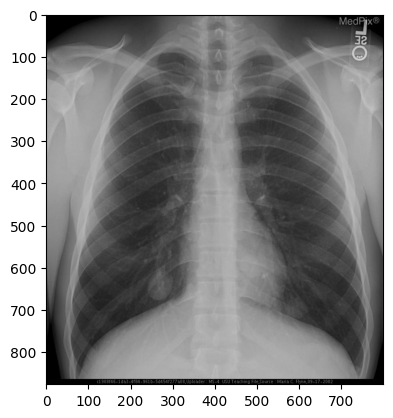

In [ ]:
# Sample data
sample = train_split[78]
print('Question:', sample['question'])
plt.imshow(sample['image'].convert('RGB'))
print('Answer:', sample['answer'])

Question: are there >5 lymph nodes located near the stomach?
Answer: yes


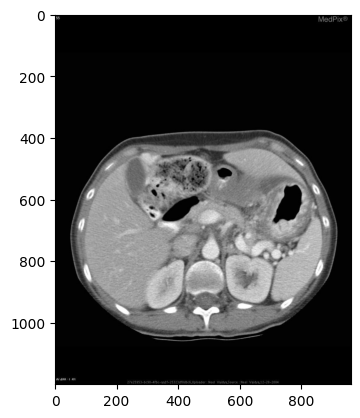

In [ ]:
# Example of closed-ended question
sample = train_split[80]
print('Question:', sample['question'])
plt.imshow(sample['image'].convert('RGB'))
print('Answer:', sample['answer'])

Question: what is meant by tram-track?
Answer: thickening of bronchi


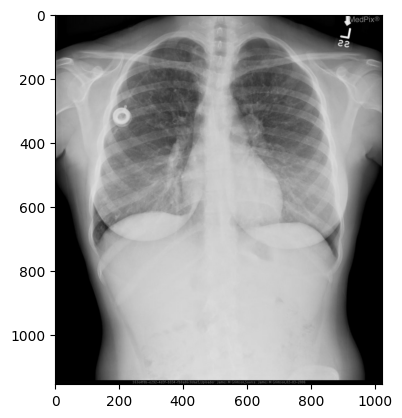

In [ ]:
# Example of open-ended question
sample = train_split[683]
print('Question:', sample['question'])
plt.imshow(sample['image'].convert('RGB'))
print('Answer:', sample['answer'])

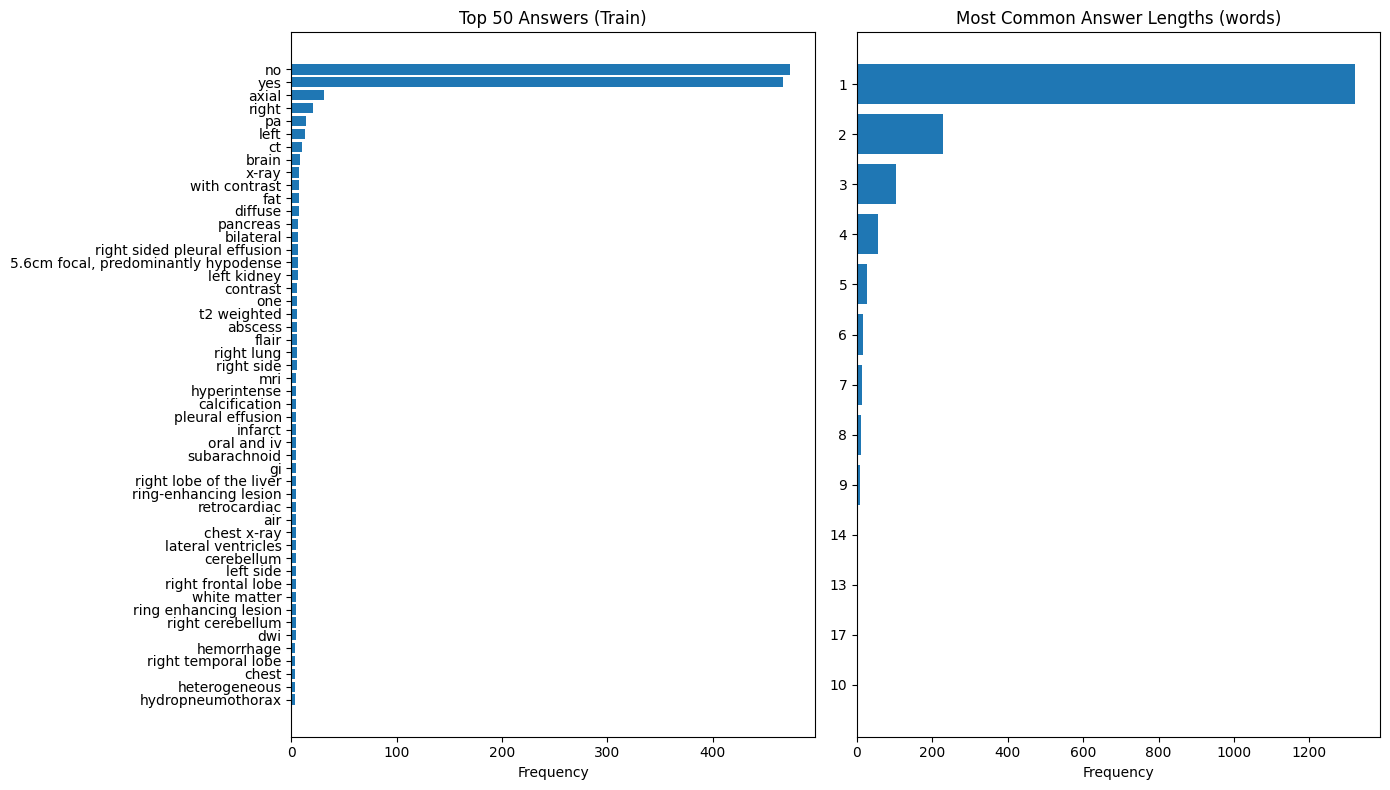

In [ ]:
answers = [s["answer"] for s in train_split]
ans_counter = Counter(answers)

# Answer length counts
ans_lengths = [len(a.split()) for a in answers]
len_counter = Counter(ans_lengths)

top50_ans = ans_counter.most_common(50)
ans_labels, ans_counts = zip(*top50_ans)

top_len = sorted(len_counter.items(), key=lambda x: x[1], reverse=True)[:50]  # if fewer than 50, it just shows all
len_labels, len_counts = zip(*top_len)

plt.figure(figsize=(14, 8))

# subplot 1: top 50 answers
plt.subplot(1, 2, 1)
plt.barh(range(len(ans_labels)), ans_counts)
plt.yticks(range(len(ans_labels)), ans_labels)
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Top 50 Answers (Train)")

# subplot 2: most common answer lengths
plt.subplot(1, 2, 2)
plt.barh(range(len(len_labels)), len_counts)
plt.yticks(range(len(len_labels)), [str(x) for x in len_labels])
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Most Common Answer Lengths (words)")

plt.tight_layout()
plt.show()

Closed vs Open Split Rule

In [ ]:
CLOSED_SET = {"yes", "no"}
def is_closed_ended(answer: str):
    return answer.lower() in CLOSED_SET

# quick counts (train)
closed_n = sum(is_closed_ended(s["answer"]) for s in train_split)
open_n = len(train_split) - closed_n
print("Train closed:", closed_n, "Train open:", open_n)

Train closed: 940 Train open: 853


Image Preprocessing + Augmentation

In [ ]:
# Base transform (no augmentation)
image_transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# Aug transform
image_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.90, 1.0)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# For BLIP
blip_pil_base = transforms.Compose([
    transforms.Resize((224, 224)),
])

blip_pil_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.90, 1.0)),
    transforms.RandomRotation(10),
])

Text Preprocessing (tokenize, vocab, encode)

In [ ]:
def tokenize(text: str):
    text = text.lower().strip()
    return re.findall(r"[a-z0-9]+", text)

def build_vocab(questions, min_freq=1):
    counter = Counter()
    for q in questions:
        counter.update(tokenize(q))

    stoi = {"<pad>": 0, "<unk>": 1}
    for w, f in counter.items():
        if f >= min_freq and w not in stoi:
            stoi[w] = len(stoi)

    itos = {i: s for s, i in stoi.items()}
    return stoi, itos

def encode_question(q: str, stoi, max_len=20):
    ids = [stoi.get(t, stoi["<unk>"]) for t in tokenize(q)][:max_len]
    ids += [stoi["<pad>"]] * (max_len - len(ids))
    return torch.tensor(ids, dtype=torch.long)

train_questions = [s["question"] for s in train_split]
stoi, itos = build_vocab(train_questions, min_freq=1)
vocab_size = len(stoi)

Answer Space (Classification labels)

In [ ]:
all_answers = [s["answer"] for s in train_split] + [s["answer"] for s in test_split]
unique_answers = sorted(set(all_answers))

answer2idx = {a: i for i, a in enumerate(unique_answers)}
idx2answer = {i: a for a, i in answer2idx.items()}
num_answers = len(answer2idx)

Dataset + DataLoaders

In [ ]:
# Classical
class VQADataset(Dataset):
    def __init__(self, split, transform, max_q_len=20):
        self.ds = split
        self.transform = transform
        self.max_q_len = max_q_len

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        s = self.ds[idx]
        image = self.transform(s["image"])
        q_ids = encode_question(s["question"], stoi, self.max_q_len)
        gt_ans = s["answer"]
        y = torch.tensor(answer2idx[gt_ans], dtype=torch.long)
        return image, q_ids, y, gt_ans

batch_size = 16
train_loader = DataLoader(VQADataset(train_split, image_transform_base), batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(VQADataset(test_split,  image_transform_base), batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
train_loader_aug = DataLoader(VQADataset(train_split, image_transform_aug), batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# BLIP
class VQARadBLIPDataset(Dataset):
    def __init__(self, split, processor, pil_transform=None, max_q_len=32, max_a_len=16):
        self.ds = split
        self.processor = processor
        self.pil_transform = pil_transform
        self.max_q_len = max_q_len
        self.max_a_len = max_a_len

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        s = self.ds[idx]
        image = s["image"].convert("RGB")
        if self.pil_transform is not None:
            image = self.pil_transform(image)

        question = s["question"]
        answer = s["answer"]

        enc = self.processor(
            images=image,
            text=question,
            padding="max_length",
            truncation=True,
            max_length=self.max_q_len,
            return_tensors="pt"
        )

        tok = self.processor.tokenizer(
            answer,
            padding="max_length",
            truncation=True,
            max_length=self.max_a_len,
            return_tensors="pt"
        )

        decoder_input_ids = tok.input_ids  # keep PAD ids here (valid token ids)
        labels = decoder_input_ids.clone()
        pad_id = self.processor.tokenizer.pad_token_id
        labels[labels == pad_id] = -100     # mask PAD for loss only

        enc = {k: v.squeeze(0) for k, v in enc.items()}
        enc["decoder_input_ids"] = decoder_input_ids.squeeze(0)
        enc["labels"] = labels.squeeze(0)
        enc["gt_answer"] = answer
        return enc

def make_blip(model_name="Salesforce/blip-vqa-base"):
    processor = BlipProcessor.from_pretrained(model_name)
    model = BlipForQuestionAnswering.from_pretrained(model_name).to(device)
    return processor, model


# BLIP loaders (Base & Aug) — kept HERE per your instruction
BLIP_BATCH = 4  # keep small for GPU memory

blip_processor_base, blip_model_base = make_blip("Salesforce/blip-vqa-base")
blip_train_loader = DataLoader(
    VQARadBLIPDataset(train_split, blip_processor_base, pil_transform=blip_pil_base),
    batch_size=BLIP_BATCH,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
blip_train_loader_aug = DataLoader(
    VQARadBLIPDataset(train_split, blip_processor_base, pil_transform=blip_pil_aug),
    batch_size=BLIP_BATCH,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
blip_test_loader = DataLoader(
    VQARadBLIPDataset(test_split, blip_processor_base, pil_transform=blip_pil_base),
    batch_size=BLIP_BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Metrics: Closed Accuracy + Open BLEU-1

In [ ]:
def normalize_text(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9 ]", "", s)
    s = re.sub(r"\s+", " ", s)
    return s

def bleu1(reference: str, hypothesis: str) -> float:
    ref = normalize_text(reference).split()
    hyp = normalize_text(hypothesis).split()
    if len(hyp) == 0:
        return 0.0

    ref_cnt = Counter(ref)
    hyp_cnt = Counter(hyp)

    matches = sum(min(hyp_cnt[w], ref_cnt.get(w, 0)) for w in hyp_cnt)
    precision = matches / len(hyp)

    r, c = len(ref), len(hyp)
    bp = 1.0 if c >= r else float(np.exp(1 - r / max(c, 1)))
    return bp * precision

def eval_closed_open(gt_answers, pred_answers):
    closed_correct = 0
    closed_total = 0
    open_bleu_sum = 0.0
    open_total = 0

    for gt, pr in zip(gt_answers, pred_answers):
        if is_closed_ended(gt):
            closed_total += 1
            if normalize_text(gt) == normalize_text(pr):
                closed_correct += 1
        else:
            open_total += 1
            open_bleu_sum += bleu1(gt, pr)

    return {
        "closed_acc": closed_correct / max(closed_total, 1),
        "open_bleu1": open_bleu_sum / max(open_total, 1),
        "closed_n": closed_total,
        "open_n": open_total
    }

Classical Model Components (CNN encoder + LSTM encoder)

In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # feature map before avgpool/fc: (B, 2048, 7, 7)
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.out_dim = 2048

    def forward(self, x):
        fmap = self.features(x)                # (B,C,H,W)
        vec = self.pool(fmap).flatten(1)       # (B,C)
        return vec, fmap

class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True)
        self.out_dim = hidden

    def forward(self, q_ids):
        emb = self.embedding(q_ids)
        _, (h, _) = self.lstm(emb)
        return h[-1]  # (B, hidden)

Model 1: Stacking (Concat Fusion)

In [ ]:
class VQA_Concat(nn.Module):
    def __init__(self, img_enc, txt_enc, num_answers):
        super().__init__()
        self.img_enc = img_enc
        self.txt_enc = txt_enc
        fusion_dim = img_enc.out_dim + txt_enc.out_dim
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_answers)
        )

    def forward(self, images, q_ids):
        img_vec, _ = self.img_enc(images)
        q_vec = self.txt_enc(q_ids)
        fused = torch.cat([img_vec, q_vec], dim=1)
        return self.classifier(fused)

Model 2: MCB Fusion (Compact Bilinear Pooling)

In [ ]:
class CountSketch(nn.Module):
    def __init__(self, in_dim, out_dim, seed=123):
        super().__init__()
        g = torch.Generator()
        g.manual_seed(seed)

        h = torch.randint(low=0, high=out_dim, size=(in_dim,), generator=g)
        s = torch.randint(low=0, high=2, size=(in_dim,), generator=g) * 2 - 1  # +/-1

        self.register_buffer("h", h)
        self.register_buffer("s", s)
        self.in_dim = in_dim
        self.out_dim = out_dim

    def forward(self, x):
        # x: (B, in_dim)
        B, D = x.shape
        out = x.new_zeros((B, self.out_dim))
        # add signed values into hashed bins
        out.scatter_add_(1, self.h.unsqueeze(0).expand(B, -1), x * self.s.unsqueeze(0))
        return out

class MCBFusion(nn.Module):
    def __init__(self, img_dim, txt_dim, mcb_dim=8000):
        super().__init__()
        self.cs_img = CountSketch(img_dim, mcb_dim, seed=1)
        self.cs_txt = CountSketch(txt_dim, mcb_dim, seed=2)
        self.mcb_dim = mcb_dim

    def forward(self, img_vec, txt_vec):
        # CountSketch
        a = self.cs_img(img_vec)  # (B,m)
        b = self.cs_txt(txt_vec)  # (B,m)

        # FFT -> multiply -> iFFT
        fa = torch.fft.rfft(a, dim=1)
        fb = torch.fft.rfft(b, dim=1)
        f = fa * fb
        out = torch.fft.irfft(f, n=self.mcb_dim, dim=1)

        # signed sqrt + l2 norm (common in bilinear pooling)
        out = torch.sign(out) * torch.sqrt(torch.abs(out) + 1e-8)
        out = F.normalize(out, dim=1)
        return out

class VQA_MCB(nn.Module):
    def __init__(self, img_enc, txt_enc, num_answers, mcb_dim=8000):
        super().__init__()
        self.img_enc = img_enc
        self.txt_enc = txt_enc
        self.mcb = MCBFusion(img_enc.out_dim, txt_enc.out_dim, mcb_dim=mcb_dim)
        self.classifier = nn.Sequential(
            nn.Linear(mcb_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_answers)
        )

    def forward(self, images, q_ids):
        img_vec, _ = self.img_enc(images)
        q_vec = self.txt_enc(q_ids)
        fused = self.mcb(img_vec, q_vec)
        return self.classifier(fused)

Model 3: Cross-Attention Fusion

In [ ]:
class VQA_CrossAttention(nn.Module):
    def __init__(self, img_enc, vocab_size, num_answers,
                 embed_dim=300, lstm_hidden=512, max_q_len=20,
                 d_model=512, n_heads=8, dropout=0.1):
        super().__init__()
        self.img_enc = img_enc
        self.max_q_len = max_q_len

        # ---- Question token encoder (keeps token outputs) ----
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, batch_first=True, bidirectional=False)

        # Project both modalities into the same d_model
        self.q_proj = nn.Linear(lstm_hidden, d_model)

        # CNN feature map is (B, C=2048, 7, 7) -> tokens (B, 49, 2048)
        self.img_proj = nn.Linear(img_enc.out_dim, d_model)

        # ---- Cross-attention block (Transformer-style) ----
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads,
                                                dropout=dropout, batch_first=True)

        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)

        # Classifier on pooled question representation
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_answers),
        )

    def forward(self, images, q_ids):
        # ---- Image tokens ----
        _, fmap = self.img_enc(images)                  # (B, 2048, 7, 7)
        B, C, H, W = fmap.shape
        img_tokens = fmap.flatten(2).transpose(1, 2)    # (B, 49, 2048)
        img_tokens = self.img_proj(img_tokens)          # (B, 49, d_model)

        # ---- Question tokens ----
        q_emb = self.embedding(q_ids)                   # (B, T, embed_dim)
        q_out, _ = self.lstm(q_emb)                     # (B, T, lstm_hidden)
        q_tokens = self.q_proj(q_out)                   # (B, T, d_model)

        # Padding mask for questions (True means "ignore")
        q_pad_mask = (q_ids == 0)                       # (B, T)

        # ---- Cross-attention: Q attends to image ----
        # Query = q_tokens, Key/Value = img_tokens
        attn_out, _ = self.cross_attn(
            query=q_tokens, key=img_tokens, value=img_tokens,
            key_padding_mask=None,          # image tokens no padding
            attn_mask=None
        )
        x = self.ln1(q_tokens + attn_out)

        # ---- Feedforward (Transformer) ----
        x = self.ln2(x + self.ff(x))

        # ---- Pool (masked mean over question tokens) ----
        mask = (~q_pad_mask).float().unsqueeze(-1)      # (B, T, 1)
        x_sum = (x * mask).sum(dim=1)                   # (B, d_model)
        denom = mask.sum(dim=1).clamp(min=1.0)          # (B, 1)
        pooled = x_sum / denom

        return self.classifier(pooled)

Model 4: BLIP (No explicit cell required)

Train + Evaluate

In [ ]:
def train_and_eval_with_history(
    model,
    train_loader,
    test_loader,
    epochs,
    lr=1e-4,
    is_blip=False,
    blip_processor=None,
    max_new_tokens=10,
    model_name="Model"
):
    """
    Unified training loop:
    - CNN models: classification CrossEntropyLoss on logits
    - BLIP: uses HuggingFace seq2seq loss and generate() for predictions
    Returns: history, metrics (closed_acc, open_bleu1, closed_n, open_n)
    """
    model = model.to(device)
    history = {"train_loss": [], "test_loss": []}

    if not is_blip:
        # ---------------- CNN CLASSIFICATION ----------------
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for ep in range(1, epochs + 1):
            model.train()
            train_loss_sum = 0.0
            train_total = 0

            for images, q_ids, labels, _gt in train_loader:
                images = images.to(device)
                q_ids = q_ids.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                logits = model(images, q_ids)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                train_loss_sum += loss.item() * labels.size(0)
                train_total += labels.size(0)

            train_loss = train_loss_sum / max(train_total, 1)
            history["train_loss"].append(train_loss)

            model.eval()
            test_loss_sum = 0.0
            test_total = 0

            with torch.no_grad():
                for images, q_ids, labels, _gt in test_loader:
                    images = images.to(device)
                    q_ids = q_ids.to(device)
                    labels = labels.to(device)

                    logits = model(images, q_ids)
                    loss = criterion(logits, labels)

                    test_loss_sum += loss.item() * labels.size(0)
                    test_total += labels.size(0)

            test_loss = test_loss_sum / max(test_total, 1)
            history["test_loss"].append(test_loss)

            print(f"[{model_name}] " f"Epoch {ep}/{epochs} | " f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

        # FINAL EVAL (closed/open)
        model.eval()
        gt_all, pred_all = [], []
        with torch.no_grad():
            for images, q_ids, labels, gt_answers in test_loader:
                images = images.to(device)
                q_ids = q_ids.to(device)

                logits = model(images, q_ids)
                preds = logits.argmax(dim=1).cpu().tolist()
                pred_texts = [idx2answer[p] for p in preds]

                gt_all.extend(list(gt_answers))
                pred_all.extend(pred_texts)

        metrics = eval_closed_open(gt_all, pred_all)
        return history, metrics

    else:
        # ---------------- BLIP GENERATIVE ----------------
        if blip_processor is None:
            raise ValueError("BLIP mode requires blip_processor=...")

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

        for ep in range(1, epochs + 1):
            model.train()
            train_loss_sum = 0.0

            for batch in train_loader:
                batch_gpu = {k: v.to(device) for k, v in batch.items() if k != "gt_answer"}
                optimizer.zero_grad()
                out = model(
                          input_ids=batch_gpu["input_ids"],
                          attention_mask=batch_gpu["attention_mask"],
                          pixel_values=batch_gpu["pixel_values"],
                          decoder_input_ids=batch_gpu["decoder_input_ids"],
                          labels=batch_gpu["labels"]
                      )
                loss = out.loss
                loss.backward()
                optimizer.step()
                train_loss_sum += loss.item()

            train_loss = train_loss_sum / max(len(train_loader), 1)
            history["train_loss"].append(train_loss)

            model.eval()
            test_loss_sum = 0.0
            with torch.no_grad():
                for batch in test_loader:
                    batch_gpu = {k: v.to(device) for k, v in batch.items() if k != "gt_answer"}
                    out = model(
                          input_ids=batch_gpu["input_ids"],
                          attention_mask=batch_gpu["attention_mask"],
                          pixel_values=batch_gpu["pixel_values"],
                          decoder_input_ids=batch_gpu["decoder_input_ids"],
                          labels=batch_gpu["labels"]
                      )
                    test_loss_sum += out.loss.item()

            test_loss = test_loss_sum / max(len(test_loader), 1)
            history["test_loss"].append(test_loss)

            print(f"[{model_name}] " f"Epoch {ep}/{epochs} | " f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


        # FINAL EVAL (closed/open) using generation
        model.eval()
        gt_all, pred_all = [], []
        with torch.no_grad():
            for batch in test_loader:
                gt_all.extend(batch["gt_answer"])

                gen_inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "pixel_values": batch["pixel_values"].to(device),
                }

                out_ids = model.generate(**gen_inputs, max_new_tokens=max_new_tokens)
                preds = blip_processor.batch_decode(out_ids, skip_special_tokens=True)
                pred_all.extend(preds)

        metrics = eval_closed_open(gt_all, pred_all)
        return history, metrics

Run 8 Models + Results DataFrame

In [ ]:
EPOCHS = 20
LR = 1e-4

# -------------------------
# Model 1: Concat (Base)
# -------------------------
img_enc = ResNetEncoder()
txt_enc = LSTMEncoder(vocab_size=vocab_size)
model_concat = VQA_Concat(img_enc, txt_enc, num_answers=num_answers)
history_concat, metrics_concat = train_and_eval_with_history(model_concat, train_loader, test_loader, epochs=EPOCHS, lr=LR, model_name="CNN + LSTM + Concat")

# -------------------------
# Model 2: Concat (Aug)
# -------------------------
img_enc = ResNetEncoder()
txt_enc = LSTMEncoder(vocab_size=vocab_size)
model_concat_aug = VQA_Concat(img_enc, txt_enc, num_answers=num_answers)
history_concat_aug, metrics_concat_aug = train_and_eval_with_history(model_concat_aug, train_loader_aug, test_loader, epochs=EPOCHS, lr=LR, model_name="Aug + CNN + LSTM + Concat")

# -------------------------
# Model 3: MCB (Base)
# -------------------------
img_enc = ResNetEncoder()
txt_enc = LSTMEncoder(vocab_size=vocab_size)
model_mcb = VQA_MCB(img_enc, txt_enc, num_answers=num_answers, mcb_dim=8000)
history_mcb, metrics_mcb = train_and_eval_with_history(model_mcb, train_loader, test_loader, epochs=EPOCHS, lr=LR, model_name="CNN + LSTM + MCB")

# -------------------------
# Model 4: MCB (Aug)
# -------------------------
img_enc = ResNetEncoder()
txt_enc = LSTMEncoder(vocab_size=vocab_size)
model_mcb_aug = VQA_MCB(img_enc, txt_enc, num_answers=num_answers, mcb_dim=8000)
history_mcb_aug, metrics_mcb_aug = train_and_eval_with_history(model_mcb_aug, train_loader_aug, test_loader, epochs=EPOCHS, lr=LR, model_name="Aug + CNN + LSTM + MCB")

# -------------------------
# Model 5: Cross-attn (Base)
# -------------------------
img_enc = ResNetEncoder()
model_attn = VQA_CrossAttention(
    img_enc=img_enc,
    vocab_size=vocab_size,
    num_answers=num_answers,
    embed_dim=300,
    lstm_hidden=512,
    d_model=512,
    n_heads=8
)
history_attn, metrics_attn = train_and_eval_with_history(model_attn, train_loader, test_loader, epochs=EPOCHS, lr=LR, model_name="CNN + LSTM + CrossAttn")

# -------------------------
# Model 6: Cross-attn (Aug)
# -------------------------
img_enc = ResNetEncoder()
model_attn_aug = VQA_CrossAttention(
    img_enc=img_enc,
    vocab_size=vocab_size,
    num_answers=num_answers,
    embed_dim=300,
    lstm_hidden=512,
    d_model=512,
    n_heads=8
)
history_attn_aug, metrics_attn_aug = train_and_eval_with_history(model_attn_aug, train_loader_aug, test_loader, epochs=EPOCHS, lr=LR, model_name="Aug + CNN + LSTM + CrossAttn")

# ==========================================================
# Model 7 & 8: BLIP (Base / Aug)
# ==========================================================
# IMPORTANT:
# - Use fresh BLIP instances so Model 8 doesn't continue Model 7's weights.
# - BLIP epochs/lr usually smaller.

BLIP_EPOCHS = 3
BLIP_LR = 5e-5

# Model 7: BLIP (Base)
blip_processor_7, blip_model_7 = make_blip("Salesforce/blip-vqa-base")
history_blip, metrics_blip = train_and_eval_with_history(
    blip_model_7,
    blip_train_loader,
    blip_test_loader,
    epochs=BLIP_EPOCHS,
    lr=BLIP_LR,
    is_blip=True,
    blip_processor=blip_processor_7,
    max_new_tokens=10,
    model_name="BLIP"
)

# Model 8: BLIP (Aug)
blip_processor_8, blip_model_8 = make_blip("Salesforce/blip-vqa-base")
history_blip_aug, metrics_blip_aug = train_and_eval_with_history(
    blip_model_8,
    blip_train_loader_aug,
    blip_test_loader,
    epochs=BLIP_EPOCHS,
    lr=BLIP_LR,
    is_blip=True,
    blip_processor=blip_processor_8,
    max_new_tokens=10,
    model_name="Aug + BLIP"
)

# -------------------------
# One results table (ALL 8)
# -------------------------
results = [
    {"model": "CNN + LSTM + Concat", **metrics_concat},
    {"model": "Aug + CNN + LSTM + Concat", **metrics_concat_aug},
    {"model": "CNN + LSTM + MCB", **metrics_mcb},
    {"model": "Aug + CNN + LSTM + MCB", **metrics_mcb_aug},
    {"model": "CNN + LSTM + CrossAttn", **metrics_attn},
    {"model": "Aug + CNN + LSTM + CrossAttn", **metrics_attn_aug},
    {"model": "BLIP", **metrics_blip},
    {"model": "Aug + BLIP", **metrics_blip_aug},
]

df_results = pd.DataFrame(results)[["model", "closed_acc", "open_bleu1", "closed_n", "open_n"]]
df_results


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


[CNN + LSTM + Concat] Epoch 1/20 | Train Loss: 4.2690 | Test Loss: 3.9243
[CNN + LSTM + Concat] Epoch 2/20 | Train Loss: 3.7146 | Test Loss: 3.6669
[CNN + LSTM + Concat] Epoch 3/20 | Train Loss: 3.1843 | Test Loss: 3.6111
[CNN + LSTM + Concat] Epoch 4/20 | Train Loss: 2.9445 | Test Loss: 3.8276
[CNN + LSTM + Concat] Epoch 5/20 | Train Loss: 2.7707 | Test Loss: 4.0795
[CNN + LSTM + Concat] Epoch 6/20 | Train Loss: 2.6083 | Test Loss: 4.3303
[CNN + LSTM + Concat] Epoch 7/20 | Train Loss: 2.4424 | Test Loss: 4.5377
[CNN + LSTM + Concat] Epoch 8/20 | Train Loss: 2.2816 | Test Loss: 4.7276
[CNN + LSTM + Concat] Epoch 9/20 | Train Loss: 2.1324 | Test Loss: 5.1426
[CNN + LSTM + Concat] Epoch 10/20 | Train Loss: 1.9556 | Test Loss: 5.4716
[CNN + LSTM + Concat] Epoch 11/20 | Train Loss: 1.8341 | Test Loss: 5.5517
[CNN + LSTM + Concat] Epoch 12/20 | Train Loss: 1.6776 | Test Loss: 5.9250
[CNN + LSTM + Concat] Epoch 13/20 | Train Loss: 1.5808 | Test Loss: 6.3326
[CNN + LSTM + Concat] Epoch 14/20 

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


[BLIP] Epoch 1/3 | Train Loss: 2.7842 | Test Loss: 2.2983
[BLIP] Epoch 2/3 | Train Loss: 1.5636 | Test Loss: 2.2596
[BLIP] Epoch 3/3 | Train Loss: 1.1225 | Test Loss: 2.3040
[Aug + BLIP] Epoch 1/3 | Train Loss: 2.7727 | Test Loss: 2.2386
[Aug + BLIP] Epoch 2/3 | Train Loss: 1.5714 | Test Loss: 2.2406
[Aug + BLIP] Epoch 3/3 | Train Loss: 1.0985 | Test Loss: 2.3704


,model,closed_acc,open_bleu1,closed_n,open_n
0,CNN + LSTM + Concat,0.589641,0.013210,251,200
1,Aug + CNN + LSTM + Concat,0.605578,0.006710,251,200
2,CNN + LSTM + MCB,0.613546,0.039712,251,200
3,Aug + CNN + LSTM + MCB,0.577689,0.076479,251,200
4,CNN + LSTM + CrossAttn,0.649402,0.130494,251,200
5,Aug + CNN + LSTM + CrossAttn,0.645418,0.145708,251,200
6,BLIP,0.557769,0.141450,251,200
7,Aug + BLIP,0.665339,0.176529,251,200


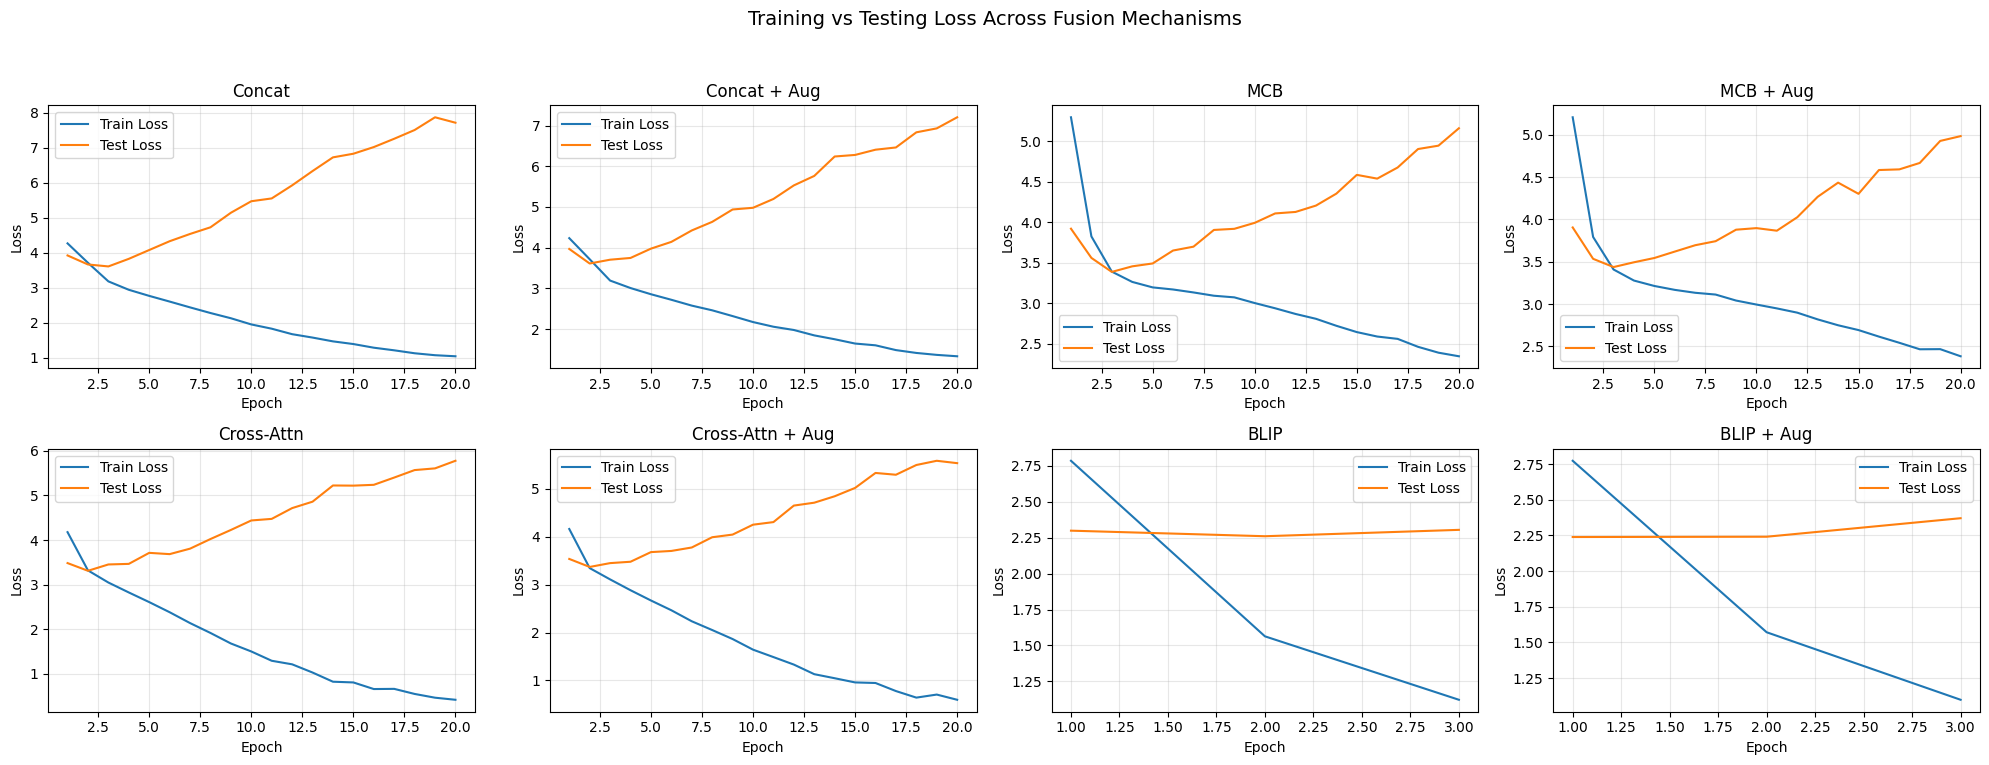

In [ ]:
def plot_loss_curves(histories, model_names):
    """
    histories: list of dicts with keys 'train_loss' and 'test_loss'
    model_names: list of strings (same length as histories)
    """

    plt.figure(figsize=(20, 8))

    for i, (hist, name) in enumerate(zip(histories, model_names), 1):
        # ✅ epoch axis computed per model (handles 20 vs 3)
        epochs = range(1, len(hist["train_loss"]) + 1)

        plt.subplot(2, 4, i)
        plt.plot(epochs, hist["train_loss"], label="Train Loss")
        plt.plot(epochs, hist["test_loss"], label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(name)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.suptitle("Training vs Testing Loss Across Fusion Mechanisms", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_loss_curves( histories=[ history_concat, history_concat_aug, history_mcb, history_mcb_aug, history_attn, history_attn_aug, history_blip, history_blip_aug ], model_names=[ "Concat", "Concat + Aug", "MCB", "MCB + Aug", "Cross-Attn", "Cross-Attn + Aug", "BLIP", "BLIP + Aug" ] )